<a href="https://colab.research.google.com/github/santule/ERA/blob/main/S7/Session_7_Model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolution block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3), # 16,26,26
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 16, 3), # 16,24,24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        )
        # transition block 1
        self.trans_block1 = nn.Sequential(
            nn.Conv2d(16, 8, 1), # 8,24,24 - reduce channels
            nn.MaxPool2d(2, 2),  # 8,12,12 - reduce output
        )
        # convolution block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3), # 8,10,10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3), # 8,8,8
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3), # 8,6,6
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        )
        # final block
        self.final_block = nn.Sequential(
            nn.Conv2d(16,10,1), # 10,6,6
            nn.AvgPool2d(kernel_size=6), # 10
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans_block1(x)
        x = self.conv2(x)
        x = self.final_block(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,168
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             136
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,168
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return correct / len(test_loader.dataset)

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test_accuracy = test(model, device, test_loader)
    scheduler.step(test_accuracy)

EPOCH: 0


Loss=0.11628752201795578 Batch_id=468 Accuracy=86.84: 100%|██████████| 469/469 [00:30<00:00, 15.36it/s]



Test set: Average loss: 0.1232, Accuracy: 9665/10000 (96.65%)

EPOCH: 1


Loss=0.05342138931155205 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]



Test set: Average loss: 0.0619, Accuracy: 9812/10000 (98.12%)

EPOCH: 2


Loss=0.017728865146636963 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]



Test set: Average loss: 0.0473, Accuracy: 9855/10000 (98.55%)

EPOCH: 3


Loss=0.04214078187942505 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]



Test set: Average loss: 0.0380, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.19388256967067719 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]



Test set: Average loss: 0.0298, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Loss=0.023206444457173347 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]



Test set: Average loss: 0.0325, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.08908644318580627 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]



Test set: Average loss: 0.0418, Accuracy: 9875/10000 (98.75%)

EPOCH: 7


Loss=0.04547544941306114 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]



Test set: Average loss: 0.0284, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.07582641392946243 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]



Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.08011447638273239 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]



Test set: Average loss: 0.0245, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.02238980121910572 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]



Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.09723318368196487 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]



Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.03405528888106346 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]



Test set: Average loss: 0.0245, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.026796214282512665 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]



Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.10185856372117996 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 18.96it/s]



Test set: Average loss: 0.0232, Accuracy: 9922/10000 (99.22%)



Text(0.5, 1.0, 'Test Accuracy')

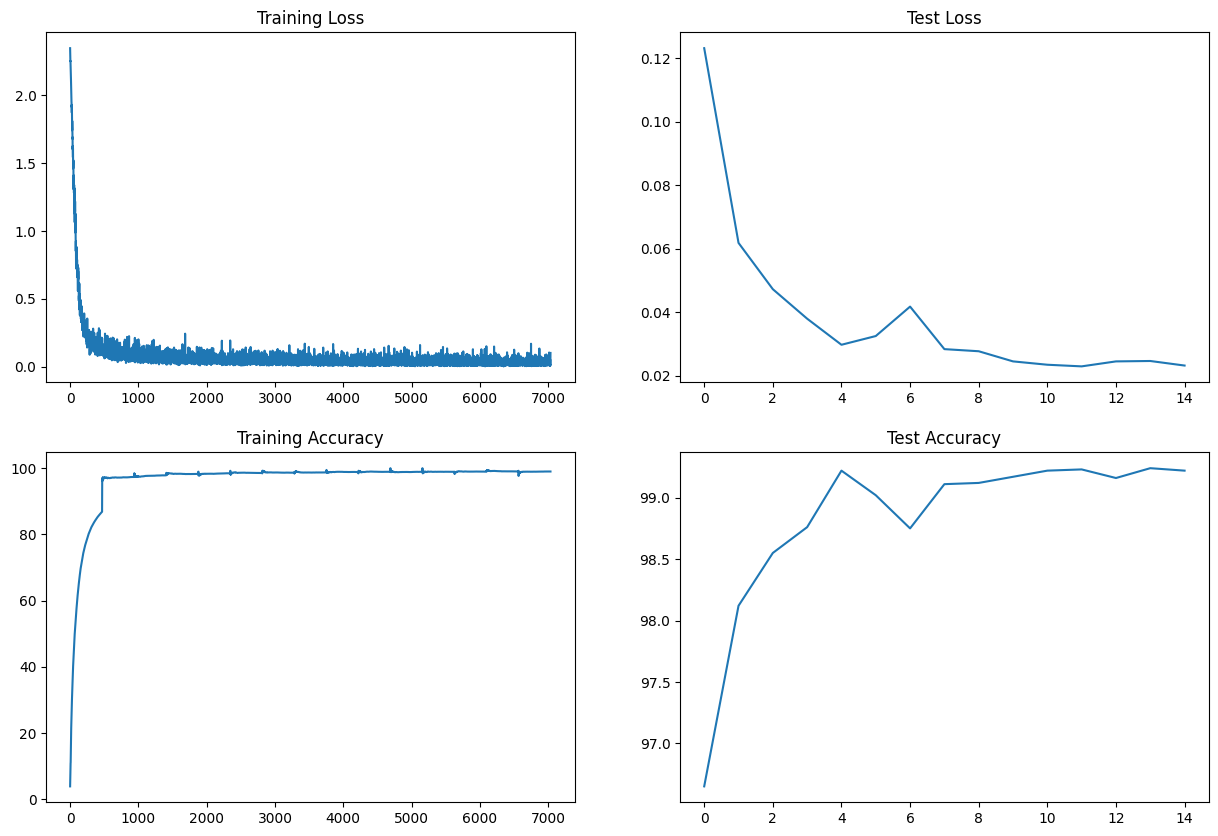

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")